<a href="https://colab.research.google.com/github/GloriousSNK/GNNFingers-Reproduction/blob/main/GNNFingers_Reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install torch
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.2.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html


In [28]:
import os, math, random, time, json
from dataclasses import dataclass
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_undirected
from sklearn.metrics import roc_auc_score

# For consistent results across runs/machines
def make_deterministic(seed: int = 123):
    os.environ["PYTHONHASHSEED" ] = str(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Fixes random seed for consistent results
make_deterministic(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[info] Using device: {device}")

[info] Using device: cpu


In [29]:
# Get standard datasets
task_kind = os.environ.get("TASK_KIND", "nodecls")
dataset_name = os.environ.get("DATASET", "Cora")

# Creates a citation dataset
dataset = Planetoid(root='data/Planetoid', name=dataset_name)
data = dataset[0].to(device)
print(f"[info] Dataset: { dataset_name} | nodes ={data.num_nodes} | feat={data.num_node_features} | classes={dataset.num_classes} ")

# Simple GCN and GraphSAGE to classify nodes
class SmallGCN(nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_ch,hid_ch, normalize = True)
        self.conv2 = GCNConv(hid_ch, out_ch, normalize= True)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight= None):
        x= self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x =  F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index , edge_weight=edge_weight)
        return x

class SmallSAGE(nn.Module):
    def __init__(self, in_ch,  hid_ch, out_ch, dropout= 0.5):
        super().__init__()
        self.conv1= SAGEConv(in_ch, hid_ch)
        self.conv2 = SAGEConv(hid_ch, out_ch)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def build_target(kind="gcn"):
    if kind == "sage":
        return SmallSAGE(dataset.num_node_features, 64, dataset.num_classes).to(device)
    return SmallGCN(dataset.num_node_features, 64, dataset.num_classes).to(device)

[info] Dataset: Cora | nodes =2708 | feat=1433 | classes=7 


In [30]:
# Trains one pass through the training data
def run_train_epoch(m, feat, ei, mask, labels, opt, edge_weight =None):
    m.train()
    opt.zero_grad()
    out = m( feat, ei, edge_weight=edge_weight )
    loss = F.cross_entropy(out[mask],labels[mask])
    loss.backward( )
    opt.step()

    return loss.item()

# Checks accuracy of prediction
@torch.no_grad()
def eval_split(m, feat, ei, labels, mask, edge_weight = None):
    m.eval()
    logits = m(feat, ei, edge_weight = edge_weight)
    predict = logits.argmax(dim=1)
    accuracy = (predict[mask] == labels[mask]).float().mean().item()

    return accuracy, logits

In [31]:
make_deterministic(10)
target_model = build_target(kind=os.environ.get("TARGET_ARCH","gcn"))
opt_main = torch.optim.Adam(target_model.parameters(), lr = 0.01, weight_decay = 5e-4)

# Keep best version of model based off validation data
best_val, best_state = 0.0, None

# Train model for 200 steps
for ep in range(1, 201):
    loss = run_train_epoch(target_model,data.x, data.edge_index, data.train_mask, data.y, opt_main)
    va, _ = eval_split(target_model, data.x, data.edge_index, data.y, data.val_mask)
    te, _ = eval_split(target_model, data.x, data.edge_index, data.y, data.test_mask)

    if va > best_val:
        best_val = va
        best_state = {k:v.detach().cpu().clone() for k, v in target_model.state_dict().items() }
    if ep in (1, 50, 100, 150, 200):
        print(f"[target] ep= {ep:3d} | loss = {loss:.4f} | val = {va:.4f} | test = {te:.4f}")

if best_state:
    target_model.load_state_dict({k:v.to(device) for k, v in best_state.items()})
torch.save(target_model.state_dict(), "./target_main.pt")


[target] ep=   1 | loss = 1.9364 | val = 0.4400 | test = 0.4440
[target] ep=  50 | loss = 0.0149 | val = 0.7760 | test = 0.8030
[target] ep= 100 | loss = 0.0163 | val = 0.7780 | test = 0.8130
[target] ep= 150 | loss = 0.0110 | val = 0.7720 | test = 0.8010
[target] ep= 200 | loss = 0.0089 | val = 0.7780 | test = 0.8050


In [33]:
def copy_model_like(m):
    new_m = build_target(kind="gcn" if isinstance(m, SmallGCN) else "sage")
    new_m.load_state_dict(m.state_dict() )

    return new_m

# Adjusts onlt last layer
def fine_tune_last_layer(m, steps=10, lr=0.01):
    # freeze except last conv
    for p in m.parameters():
        p.requires_grad = False
    last = None
    for module in m.modules():
        if isinstance(module, (GCNConv, SAGEConv)):
            last = module

    for p in last.parameters():
        p.requires_grad = True
    opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr =lr, weight_decay= 5e-4)

    for _ in range(steps):
        run_train_epoch(m, data.x, data.edge_index, data.train_mask, data.y,opt)
    return m

# Clears last layer and retrains it
def partial_reinit_and_train(m, steps=10, lr=0.01):
    # reinit last conv and trains it
    last = None
    for module in m.modules():
        if isinstance(module, (GCNConv, SAGEConv) ):
            last = module

    if hasattr(last, 'reset_parameters'):
        last.reset_parameters()
    opt = torch.optim.Adam(m.parameters(), lr= lr, weight_decay = 5e-4)

    for _ in range(steps ):
        run_train_epoch(m, data.x, data.edge_index, data.train_mask, data.y, opt)
    return m

# Tunes model for a short time
def fine_tune_all(m, steps=10, lr=0.005):
    opt = torch.optim.Adam(m.parameters(), lr=lr, weight_decay=5e-4)

    for _ in range(steps):
        run_train_epoch(m, data.x, data.edge_index, data.train_mask, data.y, opt)
    return m

# Build the suspects
suspects: List[Tuple[str, str, int]] = [ ]

# Positives (F+): variations from the target depending on the paper also fine-tunes and partial retrains
make_deterministic(11)
m1 = copy_model_like(target_model)
suspects.append(("ft_last", "./ft_last.pt", 1))
torch.save(fine_tune_last_layer(m1).state_dict(), suspects[-1][1])

make_deterministic(12)
m2 = copy_model_like(target_model)
suspects.append(("reinit_last", "./reinit_last.pt", 1))
torch.save(partial_reinit_and_train(m2).state_dict(), suspects[-1][1])

make_deterministic(13)
m3 = copy_model_like(target_model)
suspects.append(("ft_all", "./ft_all.pt", 1) )
torch.save(fine_tune_all(m3).state_dict(), suspects[-1][1])

# Negatives (F-): independently initialized and trained models

# Trains new model at different locations
for seed in (100, 101, 102):
    make_deterministic(seed)
    mn = build_target(kind=os.environ.get("NEG_ARCH", "gcn"))
    opt = torch.optim.Adam(mn.parameters(), lr=0.01, weight_decay=5e-4)

    for _ in range(100):
        run_train_epoch(mn, data.x, data.edge_index, data.train_mask, data.y, opt)
    path = f"./neg_{seed}.pt"

    torch.save(mn.state_dict(), path)
    suspects.append((f"neg_{seed}", path, 0))

# Always include the exact target as a positive example
torch.save(target_model.state_dict(), "./target_main.pt")
suspects.insert(0, ("target", "./target_main.pt", 1))

print("[info] Built suspects:", [s[0] for s in suspects] )

[info] Built suspects: ['target', 'ft_last', 'reinit_last', 'ft_all', 'neg_100', 'neg_101', 'neg_102']


In [34]:
@dataclass
class FingerprintSpec:
    num_graphs: int =64 # N in paper
    num_nodes: int = 32 # n in paper
    edge_density: float = 0.05 # p/epsilon in paper for init
    proj_every: int = 25 # steps between adjacency hardening
    update_feat: bool = True # update X
    update_adj: bool = True # update A via continuous weights + projection
    node_sample: int= 0 # if > 0, sample m nodes per fp for outputs, else use all and mean

fp_cfg = FingerprintSpec()

# feature ranges for clipping
feat_min = float (data.x.min().item())
feat_max = float(data.x.max().item())

class LearnableFingerprint(torch.nn.Module):
    # Random node feature and random guess to which nodes are connected
    def __init__ (self, num_nodes, feat_dim, density=0.05):
        super().__init__()
        self.num_nodes = num_nodes
        self.feat = nn.Parameter(torch.randn(num_nodes, feat_dim) * 0.1)
        self.adj_param= nn.Parameter(torch.randn(num_nodes, num_nodes) *-3.0)

        with torch.no_grad():
            mask = torch.rand(num_nodes, num_nodes) <density
            mask.fill_diagonal_(0)
            self.adj_param[mask] = 3.0
            # Ensure symmetry in parameters
            ap = (self.adj_param + self.adj_param.t())/2.0
            self.adj_param.copy_(ap)

        src,dst = torch.where(~torch.eye(num_nodes, dtype=torch.bool))
        self.register_buffer("edge_index_all", torch.stack([src,dst], dim=0))

    def current_edge_weight(self):
        w = torch.sigmoid(self.adj_param)
        ew = w[self.edge_index_all[0], self.edge_index_all[1]]
        return ew

    # Keeps strongest connections only
    def harden_topk(self):
        with torch.no_grad():
            w = torch.sigmoid(self.adj_param)

            iu = torch.triu_indices(self.num_nodes, self.num_nodes, offset=1)
            wu = w[iu[0], iu[1]]
            k = max(1, int(fp_cfg.edge_density *wu.numel()))
            vals, idx =torch.topk(wu, k)
            keep = torch.zeros_like(wu, dtype = torch.bool)
            keep[idx]= True
            bin_u = torch.zeros_like(wu)
            bin_u[keep] = 1.0

            w_new = torch.zeros_like(w)
            w_new[iu[0], iu[1]] = bin_u
            w_new = w_new + w_new.t()

            eps = 1e-3
            w_new.clamp_(0, 1)
            p_new = torch.log((w_new + eps)/(1 - w_new + eps))
            self.adj_param.copy_((p_new + p_new.t())/ 2.0)

    # Runs edge_index_all(static) and edge_weight from adj_param
    def forward(self, model):
        ew = self.current_edge_weight()
        logits = model(self.feat, self.edge_index_all, edge_weight=ew)

        return logits

# Create the pool of fingerprints
fp_pool: List[LearnableFingerprint] = [
    LearnableFingerprint(fp_cfg.num_nodes, data.num_features, fp_cfg.edge_density).to(device)
    for _ in range(fp_cfg.num_graphs)
    ]


In [35]:
# Determine if suspect is valid or not
class Univerifier(nn.Module):
    def __init__(self, in_dim, hidden=[128, 64,32], p= 0.1):
        super().__init__ ()
        dims = [in_dim] + hidden + [2]
        layers = []

        for i in range(len(dims) -2):
            layers += [nn.Linear(dims[i], dims[i+1]), nn.LeakyReLU(), nn.Dropout(p)]
        layers+= [nn.Linear(dims[-2],dims[-1])]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [36]:
def load_model_from(path):
    m = build_target(kind=os.environ.get("TARGET_ARCH",  "gcn"))
    m.load_state_dict(torch.load(path, map_location=device))
    m.to(device).eval()

    return m

model_entries = [(nm, load_model_from(pth), lbl) for (nm, pth,lbl) in suspects]

# Gives fingerprints to suspect model and records prediction
def get_signature_from_model(m, fps: List[LearnableFingerprint], m_nodes: int = 0):
    pieces = [ ]
    with torch.no_grad():
        for fp in fps:
            out = fp.forward(m)

            if m_nodes and m_nodes> 0 and m_nodes < fp.num_nodes:
                idx = torch.randperm(fp.num_nodes, device=out.device)[:m_nodes]
                probs = out[idx].softmax(dim=- 1).mean(dim= 0)
            else:
                probs = out.softmax(dim=-1).mean(dim=0)
            pieces.append(probs)

    return torch.cat(pieces, dim=0)

# Initialize univerifier with the correct input dimension
dummy_sig = get_signature_from_model(model_entries[0][1], fp_pool, m_nodes=fp_cfg.node_sample)
uv = Univerifier(in_dim=dummy_sig.numel()).to(device)

# Two optimizers, one for fingerprints (features + adjacency), one for the univerifier
fp_params = []
for fp in fp_pool:
    if fp_cfg.update_feat:
        fp_params.append(fp.feat)

    if fp_cfg.update_adj:
        fp_params.append(fp.adj_param)

opt_fp = torch.optim.Adam(fp_params, lr=0.05)
opt_uv = torch.optim.Adam(uv.parameters(), lr=1e-3, weight_decay=1e-4)

joint_steps = int(os.environ.get("JOINT_STEPS", "300"))
print(f"[info] Joint steps: {joint_steps} | proj_every={fp_cfg.proj_every} | update_feat={fp_cfg.update_feat} | update_adj={fp_cfg.update_adj}")

for step in range(1, joint_steps+1):
    uv.train()
    total_loss = 0.0
    batch_inputs, batch_labels = [], [ ]

    for (nm, mdl, lbl) in model_entries:
        sig_pieces = []

        for fp in fp_pool:
            out = fp.forward(mdl)

            if fp_cfg.node_sample and fp_cfg.node_sample > 0 and fp_cfg.node_sample <fp.num_nodes:
                idx = torch.randperm(fp.num_nodes, device=out.device)[:fp_cfg.node_sample]
                probs = out[idx].softmax(dim= -1).mean(dim=0)
            else:
                probs = out.softmax(dim=-1).mean(dim=0)
            sig_pieces.append(probs)

        sig_all = torch.cat(sig_pieces, dim=0)
        batch_inputs.append(sig_all.unsqueeze( 0))
        batch_labels.append(torch.tensor([lbl], device=device,dtype=torch.long) )

    Xb =torch.cat(batch_inputs, dim= 0)
    yb = torch.cat(batch_labels, dim=0)
    logits = uv(Xb.float())
    loss = F.cross_entropy(logits,yb)
    total_loss = loss

    opt_uv.zero_grad()
    opt_fp.zero_grad()
    total_loss.backward()

    with torch.no_grad() :
        for fp in fp_pool:
            if fp_cfg.update_feat:
                fp.feat.clamp_(feat_min, feat_max)

    opt_uv.step()
    opt_fp.step()

    if fp_cfg.update_adj and (step % fp_cfg.proj_every == 0 or step == joint_steps):
        for fp in fp_pool:
            fp.harden_topk()

    if step % 25 == 0 or step == 1 or step == joint_steps:
        with torch.no_grad():
            probs = logits.softmax(dim=1)[:,1]
            avg_pos = probs[(yb==1) ].mean().item() if (yb == 1).any() else float('nan')
            avg_neg = probs[(yb==0)].mean().item()  if (yb == 0).any() else float('nan')

        print(f"[joint] step={step:3d} | loss={total_loss.item():.4f} | avg_pos={avg_pos:.3f} | avg_neg={avg_neg:.3f}")

# Save learned artifacts
torch.save(uv.state_dict(),"./univerifier.pt")
torch.save({f"fp_{i}": (fp.feat.detach().cpu(), fp.adj_param.detach().cpu() ) for i, fp in enumerate(fp_pool)},"./fingerprints.pt")

[info] Joint steps: 300 | proj_every=25 | update_feat=True | update_adj=True
[joint] step=  1 | loss=0.6821 | avg_pos=0.548 | avg_neg=0.546
[joint] step= 25 | loss=0.4522 | avg_pos=0.720 | avg_neg=0.458
[joint] step= 50 | loss=0.0022 | avg_pos=0.998 | avg_neg=0.003
[joint] step= 75 | loss=0.0008 | avg_pos=0.999 | avg_neg=0.000
[joint] step=100 | loss=0.0001 | avg_pos=1.000 | avg_neg=0.000
[joint] step=125 | loss=0.0003 | avg_pos=1.000 | avg_neg=0.001
[joint] step=150 | loss=0.0001 | avg_pos=1.000 | avg_neg=0.000
[joint] step=175 | loss=0.0001 | avg_pos=1.000 | avg_neg=0.000
[joint] step=200 | loss=0.0000 | avg_pos=1.000 | avg_neg=0.000
[joint] step=225 | loss=0.0000 | avg_pos=1.000 | avg_neg=0.000
[joint] step=250 | loss=0.0000 | avg_pos=1.000 | avg_neg=0.000
[joint] step=275 | loss=0.0001 | avg_pos=1.000 | avg_neg=0.000
[joint] step=300 | loss=0.0001 | avg_pos=1.000 | avg_neg=0.000


In [37]:
@torch.no_grad()
def collect_signatures_all(models, fps, m_nodes=0):
    bag = []

    for (_, mdl, _lbl) in models:
        bag.append(get_signature_from_model(mdl, fps, m_nodes=m_nodes).unsqueeze(0))
    X = torch.cat(bag, dim=0)  # (num_models, N*C)

    return X

@torch.no_grad()
def evaluate_curves(uv, models, fps, thresholds=None):
    uv.eval()

    if thresholds is None:
        thresholds = torch.linspace(0.0, 1.0, steps =101)

    labels = torch.tensor([lbl for (_, _, lbl) in models], device=device)
    X = collect_signatures_all(models, fps, m_nodes=fp_cfg.node_sample).to(device).float()
    logits =uv(X)
    prob_pos = logits.softmax(dim=1)[:,1]

    # Save raw outputs for ROC
    labels_list = labels.detach().cpu().numpy().tolist()
    probs_list = prob_pos.detach().cpu().numpy().tolist()

    pos_mask = labels == 1
    neg_mask = labels == 0

    rob_list, uniq_list, acc_list = [],[],[]
    for t in thresholds:
        pred_pos = (prob_pos >=t).long()
        tp = ((pred_pos == 1) &pos_mask).sum().item()
        tn = ((pred_pos == 0) & neg_mask).sum().item()

        p_total= pos_mask.sum().item()
        n_total = neg_mask.sum().item()

        robustness = tp /max(1, p_total)
        uniqueness= tn / max(1, n_total)

        mean_acc =(tp + tn) / max(1, (p_total +n_total))
        rob_list.append(robustness)
        uniq_list.append(uniqueness)
        acc_list.append(mean_acc)

    # ARUC
    import numpy as np
    inter = np.minimum(np.array(rob_list), np.array(uniq_list ))
    aruc = float(np.trapz(inter, x=np.linspace(0, 1, len(inter))))

    auc_val = roc_auc_score(labels_list, probs_list)

    return {
        "thresholds": thresholds.tolist(),
        "robustness": rob_list,
        "uniqueness": uniq_list,
        "mean_accuracy": acc_list,
        "ARUC": aruc,
        "ROC_AUC": auc_val,
        "labels": labels_list,
        "probs": probs_list
    }


In [38]:
# Evaluate after joint training
metrics = evaluate_curves(uv, model_entries, fp_pool)

# Overwrite the JSON with the new version
import json
with open("./verification_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved verification_metrics.json with labels and probs included.")

Saved verification_metrics.json with labels and probs included.


/tmp/ipython-input-505843979.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aruc = float(np.trapz(inter, x=np.linspace(0, 1, len(inter))))


In [39]:
!head -n 20 verification_metrics.json

{
  "thresholds": [
    0.0,
    0.009999999776482582,
    0.019999999552965164,
    0.029999999329447746,
    0.03999999910593033,
    0.04999999701976776,
    0.05999999865889549,
    0.07000000029802322,
    0.07999999821186066,
    0.08999999612569809,
    0.09999999403953552,
    0.10999999940395355,
    0.11999999731779099,
    0.12999999523162842,
    0.14000000059604645,
    0.14999999105930328,
    0.1599999964237213,
    0.17000000178813934,


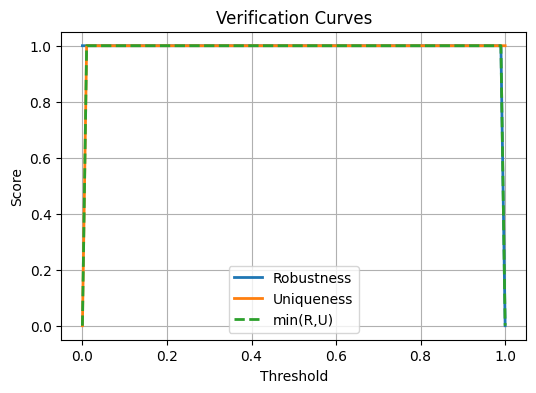

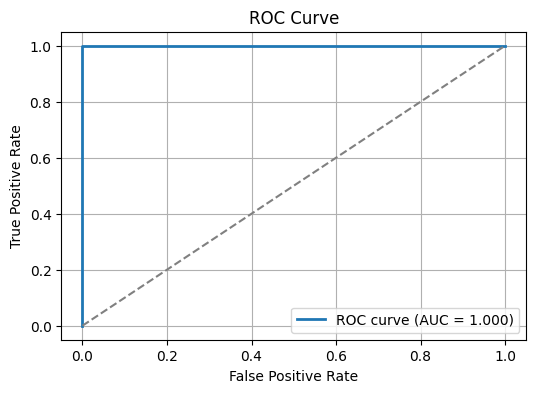

ARUC: 0.99
ROC-AUC: 1.0
Mean test accuracy: 0.9900990099009901


In [40]:

# Load metrics
with open("verification_metrics.json") as f:
    metrics = json.load(f)

thresholds =np.array(metrics["thresholds"])
robustness=np.array(metrics["robustness"])
uniqueness = np.array(metrics["uniqueness"])
intersection = np.minimum(robustness, uniqueness)

# Verification Curves
plt.figure(figsize=(6, 4))
plt.plot(thresholds, robustness, label="Robustness", lw = 2)
plt.plot( thresholds, uniqueness, label="Uniqueness", lw = 2)
plt.plot(thresholds, intersection, "--", label="min(R,U)", lw = 2)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Verification Curves")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve
labels = np.array(metrics["labels"] )
probs = np.array(metrics["probs"])

fpr, tpr, _ =roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure (figsize =(6,4))
plt.plot(fpr, tpr, label = f"ROC curve (AUC = {roc_auc:.3f})", lw = 2)
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Summary numbers
print("ARUC:", metrics["ARUC" ])
print("ROC-AUC:", metrics["ROC_AUC"])
print("Mean test accuracy:", np.mean(metrics["mean_accuracy"]))